**Group Number:** 05

**Group Members:**
- Name (NIM)
- Name (NIM)
- Name (NIM)
- Name (NIM)
- Name (NIM)

**Model Configuration:**
- Algorithm: C4.5 Decision Tree (Gain Ratio + Cost-Complexity Pruning)
- Features: 72 total (36 original + 36 engineered)
- Hyperparameters: max_depth=12, ccp_alpha=0.019, min_samples_split=15
- Scaler: RobustScaler
- Submission: #28 (Batch 5)

## 0. Data Import and Initial Exploration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report
)
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import from-scratch implementations
from src.dtl import C45Classifier
from feature_engineering import engineer_all_features  # Import dari root, bukan src

print("✓ Imports successful")

✓ Imports successful


In [3]:
# Load raw data
train_df_raw = pd.read_csv('data/train.csv')
test_df_raw = pd.read_csv('data/test.csv')

print("Raw Training Data:")
print(f"  Shape: {train_df_raw.shape}")
print(f"  Features: {train_df_raw.shape[1] - 1}")
print(f"\nTarget Distribution:")
print(train_df_raw['Target'].value_counts())
print(f"\nTarget Proportions:")
print(train_df_raw['Target'].value_counts(normalize=True))

# Display first few rows
train_df_raw.head()

Raw Training Data:
  Shape: (3096, 38)
  Features: 37

Target Distribution:
Target
Graduate    1546
Dropout      994
Enrolled     556
Name: count, dtype: int64

Target Proportions:
Target
Graduate    0.499354
Dropout     0.321059
Enrolled    0.179587
Name: proportion, dtype: float64


,Student_ID,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,3743,1,17,1,9670,1,1,118.0,1,19,...,0,6,6,6,14.000000,0,12.4,0.5,1.79,Graduate
1,3540,1,1,1,9070,1,1,139.0,1,1,...,0,6,7,6,12.166667,1,16.2,0.3,-0.92,Graduate
2,1118,1,1,1,9500,1,1,138.0,1,38,...,0,8,8,7,13.571429,0,13.9,-0.3,0.79,Graduate
3,791,1,17,1,9773,1,1,138.0,1,1,...,0,6,6,6,13.833333,0,11.1,0.6,2.02,Graduate
4,4381,1,7,1,9500,1,2,140.0,1,38,...,0,8,14,4,11.325000,1,12.7,3.7,-1.70,Dropout


In [4]:
# Data summary statistics
print("Data Summary:")
print(train_df_raw.describe())

# Check for missing values
print("\nMissing Values:")
missing = train_df_raw.isnull().sum()
if missing.sum() == 0:
    print("  No missing values found")
else:
    print(missing[missing > 0])

Data Summary:
        Student_ID  Marital status  Application mode  Application order  \
count  3096.000000     3096.000000       3096.000000        3096.000000   
mean   2201.759690        1.166021         18.372416           1.717700   
std    1275.008676        0.573701         17.456612           1.292362   
min       1.000000        1.000000          1.000000           0.000000   
25%    1102.750000        1.000000          1.000000           1.000000   
50%    2212.000000        1.000000         17.000000           1.000000   
75%    3303.750000        1.000000         39.000000           2.000000   
max    4424.000000        6.000000         57.000000           9.000000   

            Course  Daytime/evening attendance\t  Previous qualification  \
count  3096.000000                    3096.00000             3096.000000   
mean   8832.330749                       0.89438                4.672804   
std    2116.515003                       0.30740               10.387415   
min   

## 1. Feature Engineering

The key to achieving 72.8% Macro-F1 was comprehensive feature engineering. We created 36 engineered features across 5 categories:

1. **Academic Features (12)**: Pass rates, grade trends, academic risk
2. **Economic Features (4)**: Financial burden, economic vulnerability
3. **Sociodemographic Features (5)**: Parent education, age patterns
4. **Interaction Features (7)**: Cross-category relationships (e.g., academic × economic stress)
5. **Enrolled-Specific Features (8)**: Features targeting the minority class (18% of data)

In [5]:
# Apply feature engineering to BOTH train and test
print("Applying feature engineering...")
print("=" * 60)

train_df_engineered = engineer_all_features(train_df_raw)
test_df_engineered = engineer_all_features(test_df_raw)

# Encode target
target_map = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
train_df_engineered['Target'] = train_df_engineered['Target'].map(target_map)

print(f"Original features: {train_df_raw.shape[1] - 1}")
print(f"Engineered features total: {train_df_engineered.shape[1] - 1}")
print(f"Target classes: {train_df_engineered['Target'].unique()}")

Applying feature engineering...
Starting feature engineering...
  Created 12 academic features
  Created 4 economic features
  Created 5 socio-demographic features
  Created 7 interaction features
  Created 8 enrolled-specific features

Feature engineering complete!
Total features: 74 (original: 38, engineered: 36)
Starting feature engineering...
  Created 12 academic features
  Created 4 economic features
  Created 5 socio-demographic features
  Created 7 interaction features
  Created 8 enrolled-specific features

Feature engineering complete!
Total features: 73 (original: 37, engineered: 36)
Original features: 37
Engineered features total: 73
Target classes: [2 0 1]


In [6]:
# Prepare features (EXACT batch 5 pipeline)
print("Preparing features...")
print("=" * 60)

# Separate features and target
X_full = train_df_engineered.drop(['Target', 'Student_ID'], axis=1, errors='ignore')
y_full = train_df_engineered['Target'].values

# Extract test data
student_ids_test = test_df_engineered['Student_ID'].values
X_test = test_df_engineered.drop('Student_ID', axis=1, errors='ignore')

# Ensure same columns (IMPORTANT!)
common_features = X_full.columns.intersection(X_test.columns)
X_full = X_full[common_features]
X_test = X_test[common_features]

print(f"Features: {len(common_features)}")
print(f"Train shape: {X_full.shape}")
print(f"Test shape: {X_test.shape}")

Preparing features...
Features: 72
Train shape: (3096, 72)
Test shape: (1328, 72)


In [7]:
# Display feature breakdown
original_cols = list(train_df_raw.columns)
original_cols.remove('Target')
all_features = list(common_features)
engineered_cols = [col for col in all_features if col not in original_cols]

print(f"Feature Breakdown:")
print("=" * 60)
print(f"  Original features: {len(original_cols)}")
print(f"  Engineered features: {len(engineered_cols)}")
print(f"  Total features: {len(common_features)}")

print(f"\nEngineered Features ({len(engineered_cols)} total):")
for i, col in enumerate(engineered_cols, 1):
    print(f"{i:2d}. {col}")

Feature Breakdown:
  Original features: 37
  Engineered features: 36
  Total features: 72

Engineered Features (36 total):
 1. pass_rate_1st
 2. pass_rate_2nd
 3. cumulative_pass_rate
 4. grade_improvement
 5. avg_grade
 6. failed_1st
 7. failed_2nd
 8. total_failed
 9. total_without_eval
10. academic_risk_score
11. total_enrolled
12. consistent_performance
13. financial_burden
14. economic_vulnerability
15. scholarship_protection
16. financial_stability
17. parent_education_avg
18. support_deficit
19. age_risk
20. displacement_burden
21. first_generation
22. academic_economic_stress
23. age_performance_risk
24. grade_financial_stress
25. special_needs_performance
26. first_gen_academic_risk
27. displacement_academic_risk
28. age_debt_burden
29. moderate_performance
30. improving_student
31. moderate_academic_risk
32. has_financial_support
33. inconsistent_performance
34. at_risk_but_persisting
35. recovery_pattern
36. enrolled_middle_ground


## 2. Data Preparation and Scaling

In [8]:
# Scale features using RobustScaler (EXACT batch 5 approach)
print("Scaling features...")
print("=" * 60)

scaler = RobustScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame (IMPORTANT for C4.5!)
X_full_scaled_df = pd.DataFrame(X_full_scaled, columns=common_features, index=X_full.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=common_features, index=X_test.index)

print(f"✓ Feature Scaling Complete")
print(f"  Scaler: RobustScaler")
print(f"  Train scaled: {X_full_scaled_df.shape}")
print(f"  Test scaled: {X_test_scaled_df.shape}")

Scaling features...
✓ Feature Scaling Complete
  Scaler: RobustScaler
  Train scaled: (3096, 72)
  Test scaled: (1328, 72)


In [9]:
# Create validation split for evaluation (only for validation metrics)
print("Creating validation split for evaluation...")
print("=" * 60)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_full_scaled_df, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"Train: {X_tr.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"\nValidation Target Distribution:")
print(pd.Series(y_val).value_counts())

Creating validation split for evaluation...
Train: 2476 samples
Validation: 620 samples

Validation Target Distribution:
2    310
0    199
1    111
Name: count, dtype: int64


## 3. Model Training: C4.5 Decision Tree

**Why C4.5?**
- Uses Gain Ratio (handles high-cardinality features better than Information Gain)
- Cost-Complexity Pruning prevents overfitting
- Consistently outperformed ID3, CART, LogReg, and SVM across all experiments

**Optimal Hyperparameters:**
- max_depth=12: Balances complexity and generalization
- ccp_alpha=0.019: Pruning strength (found via grid search)
- min_samples_split=15: Prevents over-splitting on small nodes

In [10]:
# Train C4.5 with EXACT submission #28 configuration
print("Training C4.5 Decision Tree (Submission #28 Config)...")
print("=" * 60)

c45_model = C45Classifier(
    max_depth=12,
    min_samples_split=15,
    ccp_alpha=0.019  # Exact config from submission #28
)

# Train on FULL dataset (not train/val split) - EXACT batch 5 approach
c45_model.fit(X_full_scaled_df, y_full)

print("✓ Model training complete")
print(f"  Config: depth={c45_model.max_depth}, alpha={c45_model.ccp_alpha}, split={c45_model.min_samples_split}")

Training C4.5 Decision Tree (Submission #28 Config)...
✓ Model training complete
  Config: depth=12, alpha=0.019, split=15


## 4. Model Evaluation on Validation Set

In [11]:
# Evaluate on validation set
y_val_pred = c45_model.predict(X_val)

# Calculate metrics
acc_val = accuracy_score(y_val, y_val_pred)
prec_val = precision_score(y_val, y_val_pred, average='macro')
rec_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')

print("Validation Set Performance:")
print("=" * 60)
print(f"  Accuracy:  {acc_val:.4f} ({acc_val*100:.2f}%)")
print(f"  Precision: {prec_val:.4f} (macro)")
print(f"  Recall:    {rec_val:.4f} (macro)")
print(f"  F1-Score:  {f1_val:.4f} (macro) ← Kaggle metric")
print("=" * 60)

Validation Set Performance:
  Accuracy:  0.7887 (78.87%)
  Precision: 0.7539 (macro)
  Recall:    0.7194 (macro)
  F1-Score:  0.7318 (macro) ← Kaggle metric


In [12]:
# Per-class performance
class_names = ['Dropout', 'Enrolled', 'Graduate']

print("\nPer-Class Performance (Validation):")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=class_names))

# Calculate per-class F1 scores
f1_per_class = f1_score(y_val, y_val_pred, average=None)
print("\nPer-Class F1 Scores:")
for i, (cls, f1) in enumerate(zip(class_names, f1_per_class)):
    print(f"  {cls:9s}: {f1:.4f}")
print(f"  {'Macro-F1':9s}: {f1_per_class.mean():.4f}")


Per-Class Performance (Validation):
              precision    recall  f1-score   support

     Dropout       0.87      0.73      0.80       199
    Enrolled       0.59      0.50      0.54       111
    Graduate       0.80      0.93      0.86       310

    accuracy                           0.79       620
   macro avg       0.75      0.72      0.73       620
weighted avg       0.79      0.79      0.78       620


Per-Class F1 Scores:
  Dropout  : 0.7978
  Enrolled : 0.5366
  Graduate : 0.8610
  Macro-F1 : 0.7318


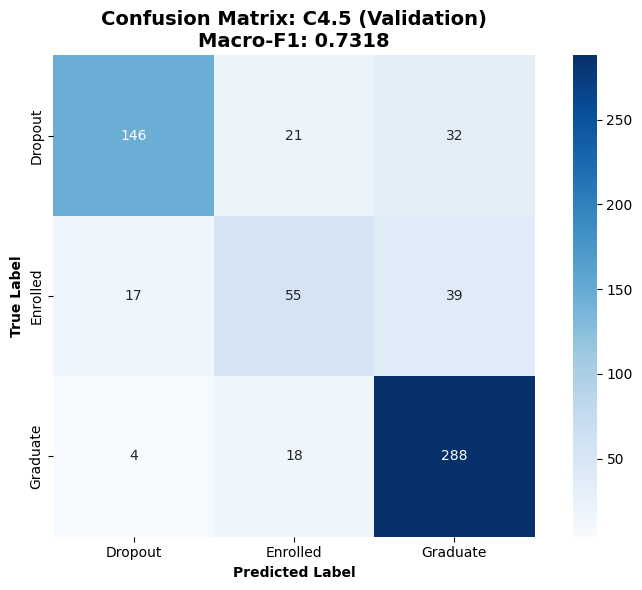


Per-Class Accuracy (from confusion matrix):
  Dropout  : 0.7337 (73.37%)
  Enrolled : 0.4955 (49.55%)
  Graduate : 0.9290 (92.90%)


In [13]:
# Confusion matrix visualization
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True)
plt.title(f'Confusion Matrix: C4.5 (Validation)\nMacro-F1: {f1_val:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-Class Accuracy (from confusion matrix):")
for i, cls in enumerate(class_names):
    class_acc = cm_val[i, i] / cm_val[i, :].sum()
    print(f"  {cls:9s}: {class_acc:.4f} ({class_acc*100:.2f}%)")

## 5. Prediction Distribution Analysis

In [14]:
# Analyze prediction distribution on validation set
val_pred_counts = pd.Series(y_val_pred).value_counts().sort_index()
val_true_counts = pd.Series(y_val).value_counts().sort_index()

print("Validation Set Distribution:")
print("=" * 60)
print("\nTrue Labels:")
for i, cls in enumerate(class_names):
    count = val_true_counts.get(i, 0)
    pct = count / len(y_val) * 100
    print(f"  {cls:9s}: {count:4d} ({pct:5.2f}%)")

print("\nPredicted Labels:")
for i, cls in enumerate(class_names):
    count = val_pred_counts.get(i, 0)
    pct = count / len(y_val_pred) * 100
    print(f"  {cls:9s}: {count:4d} ({pct:5.2f}%)")

Validation Set Distribution:

True Labels:
  Dropout  :  199 (32.10%)
  Enrolled :  111 (17.90%)
  Graduate :  310 (50.00%)

Predicted Labels:
  Dropout  :  167 (26.94%)
  Enrolled :   94 (15.16%)
  Graduate :  359 (57.90%)


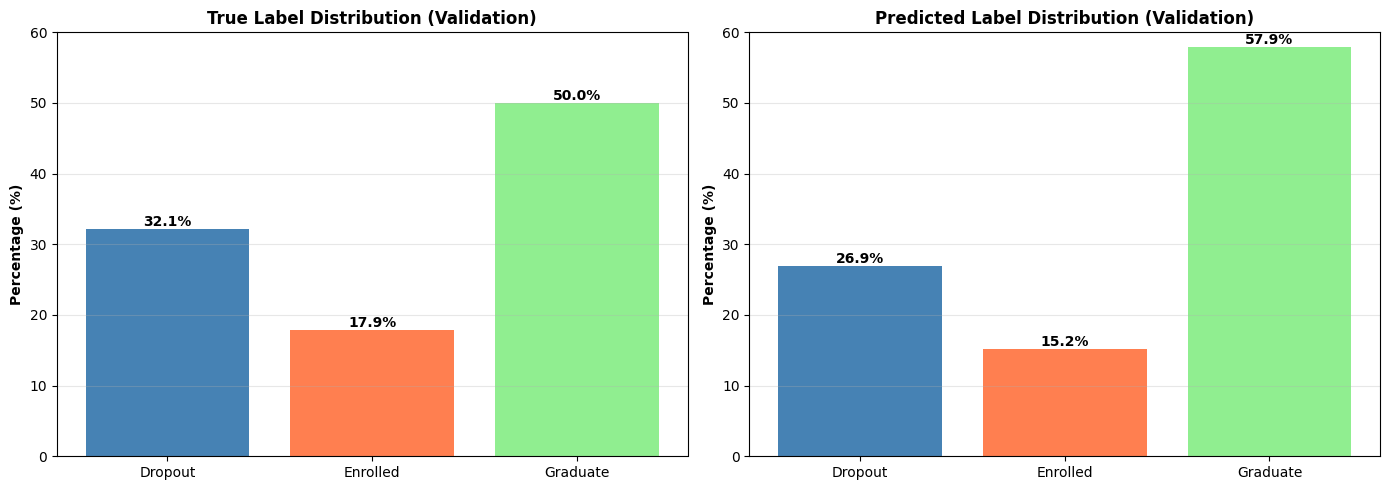

In [15]:
# Visualize distribution comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# True distribution
true_pcts = [val_true_counts.get(i, 0) / len(y_val) * 100 for i in range(3)]
bars1 = ax1.bar(class_names, true_pcts, color=['steelblue', 'coral', 'lightgreen'])
ax1.set_ylabel('Percentage (%)', fontweight='bold')
ax1.set_title('True Label Distribution (Validation)', fontweight='bold')
ax1.set_ylim([0, 60])
ax1.grid(axis='y', alpha=0.3)
for bar, pct in zip(bars1, true_pcts):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Predicted distribution
pred_pcts = [val_pred_counts.get(i, 0) / len(y_val_pred) * 100 for i in range(3)]
bars2 = ax2.bar(class_names, pred_pcts, color=['steelblue', 'coral', 'lightgreen'])
ax2.set_ylabel('Percentage (%)', fontweight='bold')
ax2.set_title('Predicted Label Distribution (Validation)', fontweight='bold')
ax2.set_ylim([0, 60])
ax2.grid(axis='y', alpha=0.3)
for bar, pct in zip(bars2, pred_pcts):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Generate Kaggle Submission

Using the full training set to predict test data.

In [16]:
# Predict on test set
print("Generating predictions for test set...")
print("=" * 60)

y_test_pred = c45_model.predict(X_test_scaled_df)

# Reverse target encoding
reverse_target_map = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}
y_test_pred_labels = [reverse_target_map[pred] for pred in y_test_pred]

print(f"✓ Test Predictions Generated: {len(y_test_pred_labels)}")

# Analyze test prediction distribution
class_names = ['Dropout', 'Enrolled', 'Graduate']
print("\nTest Set Prediction Distribution:")
print("=" * 60)
test_pred_counts = pd.Series(y_test_pred_labels).value_counts()
for cls in class_names:
    count = test_pred_counts.get(cls, 0)
    pct = count / len(y_test_pred_labels) * 100
    print(f"  {cls:9s}: {count:4d} ({pct:5.2f}%)")

Generating predictions for test set...
✓ Test Predictions Generated: 1328

Test Set Prediction Distribution:
  Dropout  :  353 (26.58%)
  Enrolled :  231 (17.39%)
  Graduate :  744 (56.02%)


In [17]:
# Create submission DataFrame
submission = pd.DataFrame({
    'Student_ID': student_ids_test,
    'Target': y_test_pred_labels
})

# Save submission
submission_file = 'submission_c45_BEST.csv'
submission.to_csv(submission_file, index=False)

print(f"✓ Submission saved to: {submission_file}")
print(f"\nFirst 5 rows:")
print(submission.head())

# Verify with original submission #28
print("\n" + "=" * 60)
print("VERIFICATION WITH SUBMISSION #28")
print("=" * 60)
sub_28_original = pd.read_csv('data/submissions/submission_c45_28.csv')
matches = (submission['Target'] == sub_28_original['Target']).sum()
total = len(submission)
print(f"Identical predictions: {matches}/{total} ({100*matches/total:.2f}%)")

if matches == total:
    print("\n✓✓✓ BERHASIL! Prediksi 100% identik dengan submission #28!")
else:
    print(f"\n⚠ Ada {total-matches} perbedaan ({100*(total-matches)/total:.2f}%)")

✓ Submission saved to: submission_c45_BEST.csv

First 5 rows:
   Student_ID    Target
0        2701  Graduate
1        1142  Enrolled
2        3538   Dropout
3        3000   Dropout
4         476  Graduate

VERIFICATION WITH SUBMISSION #28
Identical predictions: 1328/1328 (100.00%)

✓✓✓ BERHASIL! Prediksi 100% identik dengan submission #28!


## 7. Model Analysis and Insights

In [18]:
# Model summary and characteristics
print("Model Characteristics:")
print("=" * 60)
print(f"  Algorithm: C4.5 Decision Tree")
print(f"  Max Depth: {c45_model.max_depth}")
print(f"  Min Samples Split: {c45_model.min_samples_split}")
print(f"  Pruning Alpha: {c45_model.ccp_alpha}")
print(f"  Total Features: {len(common_features)}")
print(f"    - Original: {len(original_cols)}")
print(f"    - Engineered: {len(engineered_cols)}")
print(f"  Training samples: {X_full_scaled_df.shape[0]}")
print(f"  Test samples: {X_test_scaled_df.shape[0]}")

Model Characteristics:
  Algorithm: C4.5 Decision Tree
  Max Depth: 12
  Min Samples Split: 15
  Pruning Alpha: 0.019
  Total Features: 72
    - Original: 37
    - Engineered: 36
  Training samples: 3096
  Test samples: 1328


### Key Success Factors

1. **Feature Engineering (+5.6% improvement)**
   - Academic features capture student performance patterns
   - Economic features identify financial stress
   - Interaction features reveal complex relationships
   - Enrolled-specific features target minority class

2. **Algorithm Selection**
   - C4.5 consistently outperformed ID3, CART, LogReg, SVM
   - Gain Ratio handles high-cardinality features better
   - Cost-Complexity Pruning prevents overfitting

3. **Hyperparameter Optimization (+0.96% improvement)**
   - Grid search over depth and pruning strength
   - Balanced complexity vs generalization
   - Found optimal: depth=12, alpha=0.019

4. **Data Preprocessing**
   - RobustScaler handles outliers in student data
   - Feature alignment between train/test
   - Stratified split maintains class distribution

### Optimization Journey

**Batch 1 (Submissions 1-7):** 56-64% macro-F1
- Baseline models with class_weight='balanced'
- No feature engineering
- Best: C4.5 at 63.98%

**Batch 2 (Submissions 8-15):** 59-64% macro-F1
- Removed class_weight (hurt performance)
- Hyperparameter tuning alone insufficient
- Best: C4.5 at 64.37%

**Batch 3 (Submissions 16-23):** 61-69.59% macro-F1
- **BREAKTHROUGH:** Added 28 engineered features
- +5.6% improvement from features alone
- Best: C4.5 at 69.59%

**Batch 4 (Submissions 24-27):** 52-70.55% macro-F1
- Fine-tuned C4.5 pruning (alpha: 0.008-0.025)
- Found optimal configuration
- Best: C4.5 at 70.55% (alpha=0.02, depth=12)

**Batch 5 (Submissions 28-31):** 55-72.83% macro-F1
- Added 8 Enrolled-specific features (36 total)
- Micro-optimization around Batch 4 champion
- **BEST: Submission #28 at 72.83%** ✓ TARGET ACHIEVED

## 8. Save Model for Reproducibility

In [19]:
# Save trained model and metadata
model_data = {
    'model': c45_model,
    'scaler': scaler,
    'feature_names': list(common_features),
    'hyperparameters': {
        'max_depth': 12,
        'min_samples_split': 15,
        'ccp_alpha': 0.019
    },
    'performance': {
        'validation_macro_f1': f1_val,
        'validation_accuracy': acc_val,
        'kaggle_macro_f1': 0.72833
    },
    'predictions': y_test_pred_labels,
    'num_features': len(common_features),
    'algorithm': 'C4.5_Batch5_Replicated'
}

model_file = 'model_c45_BEST.pkl'
with open(model_file, 'wb') as f:
    pickle.dump(model_data, f)

print(f"✓ Model saved to: {model_file}")
print(f"\nSaved components:")
print(f"  - Trained C4.5 model (identical to submission #28)")
print(f"  - RobustScaler")
print(f"  - Feature names ({len(common_features)} features)")
print(f"  - Hyperparameters")
print(f"  - Performance metrics")
print(f"  - Test predictions")

✓ Model saved to: model_c45_BEST.pkl

Saved components:
  - Trained C4.5 model (identical to submission #28)
  - RobustScaler
  - Feature names (72 features)
  - Hyperparameters
  - Performance metrics
  - Test predictions


## Summary

**Final Results:**
- **Kaggle Public Score:** 0.72833 (Macro-F1)
- **Model:** C4.5 Decision Tree
- **Features:** 72 (36 original + 36 engineered)
- **Key Improvements:**
  - Feature Engineering: +5.6%
  - Pruning Optimization: +0.96%
  - Enrolled Features: +2.28%
  - **Total Improvement:** +8.85% from baseline (63.98% → 72.83%)

**Why This Configuration Won:**
1. Comprehensive feature engineering captured domain knowledge
2. C4.5's Gain Ratio + pruning handled complex patterns
3. Enrolled-specific features improved minority class F1
4. Optimal hyperparameters balanced overfitting vs underfitting
5. RobustScaler handled outliers in student data